<a href="https://colab.research.google.com/github/SquareGraph/FootballPredictionsModel/blob/main/BaselineModels_Football_Predictions_55_60_version_to_publish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is the model comparison notebook. 
We will cover a bunch of models with a baseline data from a English Premier League, to distingiush potential and next steps.

The main reasoning behind this research is to create the algobetting robot. Whilst mode odds on home wins and distribution are around 1,16(distribution: ~43%), away wins 1,78(dist: ~34%) and draws 3,38(dist: ~23%), it means that:
(1,16*0,43+1,78*0,34+3,38*0,23) * accuracy of prediction should set a baseline for a ROI of this robot.

And math is very clear here: 

In [1]:
sum_of_odds = 1.16*0.43+1.78*0.34+3.38*0.23
print(f"The sum of odds in one season, if we type everything correct is: {round(sum_of_odds, 3)}")
print(f"So to have non negative ROI (not counting any commisions on money transfer), our algorithms accuracy must be accurate {round(1/sum_of_odds*100, 4)}% times.")

## data based on EPL season of 2021

The sum of odds in one season, if we type everything correct is: 1.881
So to have non negative ROI (not counting any commisions on money transfer), our algorithms accuracy must be accurate 53.1519% times.


## So we'll be covering following algorithms:

1. SKlearn RandomForestClassifier (no need of explanation)
2. XGBoost Classifier (no need of explanation)
3. PyTorch TabNet implementationby Dreamquark-ai:
  <br>  a) https://github.com/dreamquark-ai/tabnet - official docs of PyTorch implementation of the original algorithm
  <br>  b) https://arxiv.org/abs/1908.07442 - official research papers of TabNet
<br> c) https://www.geeksforgeeks.org/tabnet/ - a quick guide over the TabNet

4. DeepInisght with DeppInsight like architecture:
  <br>  a) DeepInsight paper: https://www.nature.com/articles/s41598-019-47765-6 - a methodology of converting tabular data to Images, article in Nature with some data
 <br>   b) https://github.com/nicomignoni/tab2img - a documentation of the implemenation of DeepInsight in a python library 
<br>    c) Disclaimer: this is a baseline approach, so I decided just to implement the one leg of proposed net. 

In [6]:
# Let's start from importing and mounting drive, cause we'll be working on a dataset prepared before in a following notebook:
# Notebook for Data Gathering https://github.com/SquareGraph/FootballPredictionsModel/blob/main/DataGathering_from_Soccerdata.ipynb
from IPython.utils.text import Path
from google.colab import drive 
drive.mount('/content/drive')
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Paths declaration
path = Path('/content/drive/MyDrive/Github/FootballPredictionsModel')
data = 'data'

In [8]:
#Some standard imports
import pandas as pd
import numpy as np

In [9]:
main = pd.read_csv(path/data/"with_fifa_raw.csv") ; print(main.shape) # We have a lot of features here, 141!
main.head()

(380, 141)


,Unnamed: 0,date_x,home_team,away_team,game_id,Goal_x,Off Target_x,Saved_x,Woodwork_x,<10_x,...,33,34,35,36,37,38,39,40,41,42
0,0,2021-08-13 00:00:00,Brentford,Arsenal,3adf2aa7,1.500000,2.8,1.00,0.0,3.6,...,-2.757576,0.393939,-0.333333,-3.060606,-1.636364,-2.242424,-2.060606,-1.484849,-0.545455,-1.424242
1,1,2021-08-14 00:00:00,Burnley,Brighton & Hove Albion,4eb36e37,1.000000,2.6,2.00,0.0,2.2,...,1.060606,2.666667,0.212121,0.181818,-0.030303,0.333333,0.212121,0.484849,-0.454545,0.363636
2,2,2021-08-14 00:00:00,Chelsea,Crystal Palace,6f454493,1.400000,4.0,4.25,0.0,3.8,...,5.939394,3.787879,4.636363,5.151515,0.000000,1.484849,1.454546,0.151515,-0.636364,-1.666667
3,3,2021-08-14 00:00:00,Everton,Southampton,c99ebbf5,1.666667,4.0,2.00,0.0,3.0,...,6.636363,3.484849,1.878788,1.636364,0.181818,0.848485,0.363636,0.484849,0.424242,0.515151
4,4,2021-08-14 00:00:00,Leicester City,Wolverhampton Wanderers,0b346a62,1.000000,3.6,2.50,0.0,3.0,...,3.939394,3.545454,4.060606,3.151515,4.393940,3.545454,4.121212,3.454546,4.878788,2.636364


In [10]:
# list(main.columns)

In [11]:
main.dtypes[main.dtypes == "object"] # And here all non-numerical categories. 

date_x       object
home_team    object
away_team    object
game_id      object
date_y       object
dtype: object

# What to do with those features.
A Quick explanation:

1. Object data types:
   <br>a) We want to drop date_x and date_y features (as it seems not relevant to the game performance, without an information about additional games from other competition, and potential fatigue). From domain knowledge, raw date of a game it's a rubbish data I strongly believe.
    <br> b) Home_team and away_team - assign each team a number, and treat them like every other numerical data. There's some logic behind this reasoning. Explain further in the document.
    <br> c) game_id - absolutely unnecessary.

2.  Numerical data types to drop from the features:

    a) FTR - those are our Y values. We want to drop them before assining to the X values.
   <br> b) D_HT, home_point,draw_points,away_points - A lost remains of some computation did during that processing. Absolutely to drop.
  <br>  c) Unnamed: 0 - index like, probably effect of merging without droping index params. Drop.

3. Numerical data types - Legend
   <br> a) Columns named from 0 to 42: it's a SoFifa mean params, substracted between home and away.
  <br>  b) home_rank, away_rank - ELO Rank at the day of a game
  <br> c) all duplicated columns - rolling average (5 games window) for each team performance






# Team name transofmration

Probably the team name may also affect the game result. For example if you are playing against strong rival your mental approach may vary from challenging the weaker one. So let's translate team names into integer values from 1 to 20.

In [12]:
team_integers = dict(zip(np.unique(main.home_team.to_numpy()),np.arange(1,21))) #dict from zip from unique team names labeled by the np arange.
main.replace(team_integers, inplace=True) #replace all through dictionary method.

# Prepare Raw, unnormalized data for initial baseline training.

We want to start with a baseline models just from the raw data.
But let's also check if time series character vary training or not. So we will build two different datasets. One that will be randomly splited, and the second one that takes first 80% of games for a training dataset and predict on the last 20%. Let's call them X_ts,y_ts for timeserieswise variation, and X_rand, y_rand for randomly splitted.

In [13]:
main_dropped = main.drop(["date_x","date_y","game_id","Unnamed: 0","D_HT","home_point","draw_points","away_points"],axis=1) # we are dropping all columns mentioned above

In [14]:
y = main_dropped.FTR.to_numpy() #labels
X = main_dropped.drop(["FTR"],axis=1).fillna(0).to_numpy() ## all nan comes from the effect of calculating rolling average (division by 0 at some point) or no records, so filling with 0 is not a bad idea.

In [15]:
X_normalized = main_dropped.drop(["FTR"],axis=1).apply(lambda x: x/x.max()).fillna(0).to_numpy() #normalized version of X

In [16]:
## We will use our own train test split, because want to keep chronological order as those are time series data.

def train_test_split_ts(features, targets, train_size=0.8):

    """Returns two tuples of Train and test sests, in X,y order."""

    TRAIN_SIZE = int(features.shape[0]*train_size)
    X_ts_train, y_ts_train = features[:TRAIN_SIZE], targets[:TRAIN_SIZE]
    X_ts_test, y_ts_test = features[TRAIN_SIZE:], targets[TRAIN_SIZE:]



    return (X_ts_train, y_ts_train), (X_ts_test, y_ts_test)

In [17]:
train_ts, test_ts = train_test_split_ts(X_normalized,y) # split into tuples

In [18]:
#unpack tuples
X_train_ts, y_train_ts = train_ts 
X_test_ts, y_test_ts = test_ts

In [19]:
# and now the randomly splitted sklearn version of train_test_split

from sklearn.model_selection import train_test_split

X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(X,y, test_size=0.2, random_state=42)

# First model RandomForestClassifier from sklearn
We starts with a RandomForest for our absolute baseline.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [21]:
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)

In [22]:
rf.fit(X_train_ts, y_train_ts) # train the baseline model

RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=1)

In [23]:
rf_preds = np.argmax(rf.predict_proba(X_test_ts), axis=1) # make prediction and call the argmax to have an index of the highest probability

In [24]:
rf_acc = accuracy_score(y_test_ts, rf_preds) ; rf_acc#np.sum((preds == y_test_ts).astype(float))/preds.shape[0] ; accuracy # calculate the model accuracy.

0.5394736842105263

In [25]:
def check_odds(x):

    """helper function to collect Avg odds per our prediction. To apply on a DataFrame"""

    if x.FTR == 0:
        return x.AvgH
    elif x.FTR == 1:
        return x.AvgA
    elif x.FTR == 2:
        return x.AvgD

In [26]:
## check the bookmakers odds score

def check_score(main_df: pd.core.frame.DataFrame, predictions: np.array):
    
    """A simple function that returns the DataFrame of correct results and a score"""

    main_df["predictions"] = 0
    main_df.predictions[304:] = predictions

    comparsion_of_predictions = main_df[["FTR","predictions","AvgH","AvgA","AvgD"]][304:]
    filter = comparsion_of_predictions.FTR == comparsion_of_predictions.predictions

    filtered = comparsion_of_predictions[filter] 
    filtered["score_odds"] = filtered.apply(lambda x: check_odds(x), axis=1)
    score = filtered.sum(axis=0)["score_odds"]

    return filtered, score


    


In [27]:
compare_rf, score_rf = check_score(main, rf_preds) ; score_rf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


73.39999999999999

In [95]:
avg_odds_per_bet_rf = compare_rf.describe().loc["mean"]["score_odds"] ; avg_odds_per_bet_rf

1.7902439024390242

# RandomForestClassifier

So our accuracy is over the target (nearly 54%) but it looks like investing 1 dollar per each game of the last 76 game wouldn't be the best idea in the world, cause our return was 73,4 dollars. But still better then random, as we have only 33% chances of good bet!

# XGBoost - Baseline model 2

In [28]:
import xgboost as xgb

In [29]:
model_xgb_ = xgb.XGBClassifier(learning_rate=0.1,
                              max_depth=5,
                              n_estimators=100,
                              subsample=0.5,
                              colsample_bytree=0.5,
                              eval_metric='mlogloss',
                              verbosity=1) #Hyperparams



model_xgb_.fit(X_train_ts, y_train_ts, early_stopping_rounds=100, eval_set=[(X_test_ts, y_test_ts)], verbose=True) #train the model

[0]	validation_0-mlogloss:1.07159
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[1]	validation_0-mlogloss:1.05318
[2]	validation_0-mlogloss:1.04096
[3]	validation_0-mlogloss:1.01734
[4]	validation_0-mlogloss:1.00851
[5]	validation_0-mlogloss:0.993597
[6]	validation_0-mlogloss:0.988864
[7]	validation_0-mlogloss:0.981035
[8]	validation_0-mlogloss:0.980294
[9]	validation_0-mlogloss:0.975226
[10]	validation_0-mlogloss:0.973907
[11]	validation_0-mlogloss:0.969354
[12]	validation_0-mlogloss:0.971531
[13]	validation_0-mlogloss:0.96034
[14]	validation_0-mlogloss:0.951886
[15]	validation_0-mlogloss:0.949096
[16]	validation_0-mlogloss:0.942552
[17]	validation_0-mlogloss:0.944439
[18]	validation_0-mlogloss:0.945999
[19]	validation_0-mlogloss:0.941998
[20]	validation_0-mlogloss:0.950488
[21]	validation_0-mlogloss:0.95129
[22]	validation_0-mlogloss:0.956154
[23]	validation_0-mlogloss:0.955075
[24]	validation_0-mlogloss:0.954338
[25]	validation_0-mlogloss:0.951503
[26]	valida

XGBClassifier(colsample_bytree=0.5, eval_metric='mlogloss', max_depth=5,
              objective='multi:softprob', subsample=0.5)

In [30]:
xgboost_test_preds = model_xgb_.predict_proba(X_test_ts).argmax(axis=1) # make predictions and find the index of the max predictions by row

In [31]:
xgboost_acc_test = accuracy_score(y_test_ts, xgboost_test_preds) ; xgboost_acc_test # calculate Accuracy

0.5526315789473685

In [32]:
compare_xgb, score_xgb = check_score(main, xgboost_test_preds) # calculate bookmakers 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
score_xgb # And still we are below our initial investment.

75.53

In [94]:
avg_odds_per_bet_xgb = compare_xgb.describe().loc["mean"]["score_odds"] ; avg_odds_per_bet_xgb

1.7983333333333333

# XGBoost baseline performance
It was slightly better then RandomForrest, but we are still underperforming. From the other hand, we are at the level of the bookmakers accuracy, so not bad for the second shot.

# TabNet Baseline

In [34]:
!pip install pytorch_tabnet # You have to install tabnet, colab doesn't come with this one included

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
from pytorch_tabnet.tab_model import TabNetClassifier #this is the class will be using
import torch #this one is for the optimizer

In [36]:
model_tabnet = TabNetClassifier(n_d=64, n_a=64, n_steps=10,
    gamma=0, n_independent=2, n_shared=2,
    lambda_sparse=1e-5, momentum=1, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.1),
    scheduler_params = {"gamma": 0.5,
                     "step_size": 50},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
) #hyperparams of the model

Device used : cpu


In [37]:
max_epochs = 500 

In [38]:
model_tabnet.fit(X_train=X_train_ts, 
                 y_train=y_train_ts, 
                 eval_set=[(X_train_ts, y_train_ts), (X_test_ts, y_test_ts)],
                 eval_name=['train','valid'],
                 max_epochs=max_epochs, patience=100) #train the model

epoch 0  | loss: 4.86407 | train_accuracy: 0.40461 | valid_accuracy: 0.42105 |  0:00:00s
epoch 1  | loss: 12.5476 | train_accuracy: 0.27303 | valid_accuracy: 0.32895 |  0:00:01s
epoch 2  | loss: 11.52817| train_accuracy: 0.45066 | valid_accuracy: 0.5     |  0:00:01s
epoch 3  | loss: 5.76803 | train_accuracy: 0.50329 | valid_accuracy: 0.51316 |  0:00:01s
epoch 4  | loss: 5.12929 | train_accuracy: 0.30921 | valid_accuracy: 0.26316 |  0:00:02s
epoch 5  | loss: 4.21971 | train_accuracy: 0.32566 | valid_accuracy: 0.38158 |  0:00:02s
epoch 6  | loss: 1.49342 | train_accuracy: 0.34868 | valid_accuracy: 0.32895 |  0:00:02s
epoch 7  | loss: 1.64031 | train_accuracy: 0.25329 | valid_accuracy: 0.27632 |  0:00:03s
epoch 8  | loss: 1.09939 | train_accuracy: 0.47697 | valid_accuracy: 0.59211 |  0:00:03s
epoch 9  | loss: 0.77372 | train_accuracy: 0.50987 | valid_accuracy: 0.56579 |  0:00:03s
epoch 10 | loss: 0.82544 | train_accuracy: 0.53618 | valid_accuracy: 0.5     |  0:00:04s
epoch 11 | loss: 0.75

In [39]:
tabnet_predictions = model_tabnet.predict_proba(X_test_ts).argmax(axis=1) # predictions

In [40]:
tabnet_accuracy = accuracy_score(y_test_ts, tabnet_predictions)  ; tabnet_accuracy # accuracy

0.5921052631578947

In [41]:
compare_tabnet, score_tabnet = check_score(main, tabnet_predictions) # checking the score against the odds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [42]:
score_tabnet

86.09999999999998

In [93]:
avg_odds_per_bet_tabnet = compare_tabnet.describe().loc["mean"]["score_odds"] ; avg_odds_per_bet_tabnet

1.9133333333333329

# PyTorch TinyVGG + Tab2Img transformation (CNN model)
Below code is PyTorch specific and I will not be explaining erything very precisle here. If you don't know this framework specificly well and want to change it, consider this:

https://www.mrdbourke.com/pytorch-in-a-day/

In [43]:
!pip install torchmetrics # for accuracy
!pip install tab2img # for DeepInsight implementation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
import torch.nn as nn  #we previously import torch, this one is just for the module of neural nets.
from torch.utils.data import DataLoader

In [45]:
from tab2img.converter import Tab2Img # import Class to convert the tabular data into images
import requests # for downloading my custom pytorch loops and some other hlepful classess.


if Path("helper_f.py").is_file(): 
    print("Exists!")
else:
    print("Dwnld")
    request = requests.get("https://raw.githubusercontent.com/SquareGraph/HelperFunctions/main/helper_f.py")
    with open("helper_f.py", "wb") as f:
        f.write(request.content)

from helper_f import * #importing those helper functions I mentioned above

Dwnld


In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu" #device agnostic code.

In [47]:
# Now we will define a converter. It will do two things. Firstly we are about to call a class to apply transmutation on the table data.
# Secondly we will broadcast it into the NCHW format.

def tab2_img_xy(train,target,channels:int = 3):
    model_converter = Tab2Img()
    X = model_converter.fit_transform(train,target)
    dim = X[0][1].shape 

    list_of_3d_img = []
    for image in X:
        list_of_3d_img.append(np.broadcast_to(image, (channels,dim[0],dim[0]))) 

    return torch.tensor(np.array(list_of_3d_img, dtype=np.float32))


In [99]:
X_tensors_train = tab2_img_xy(X_normalized, y, 1) # calling the function to get tensors

In [100]:
X_tensors_train.shape # so we have all of our data in one tensor. Now it's time to plot it to check how it looks like.

torch.Size([380, 1, 12, 12])

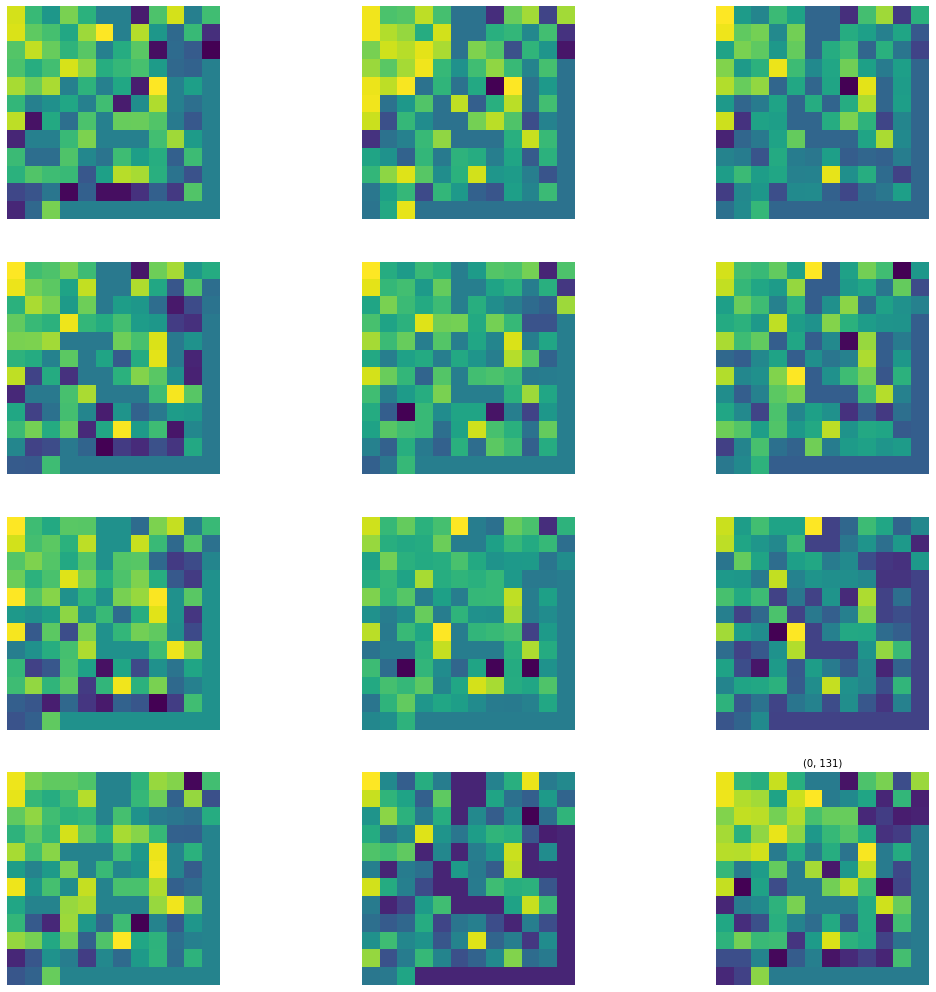

In [101]:
plot_ranom_images(0,380,12,X_tensors_train, y, (18,18), (4,3) , 10) #hleper function that takes out random sample from tensor, transmute them to the HWC format (matplotlib do not understand PyTorch native image format)

In [102]:
 # This time I'm using whole dataframe for y labels, because I have already prebuild PyTorch DataSet Class that will handle extracting y values.
train_tensor, test_tensor = train_test_split_ts(X_tensors_train, main, train_size=0.8)

In [103]:
X_train_tensor, y_train_tensor = train_tensor
X_test_tensor, y_test_tensor = test_tensor # unpacking tuples

In [104]:
def get_classes(series: pd.core.series.Series):

    classes = series.unique()
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

class MatchesDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 dataframe: pd.core.frame.DataFrame, #dataframe of results, we will gety Y_labels from this
                 games: torch.Tensor, #tensor of X's
                 transform=None): #we will not be using any transorm at this stage, but I'll leave as a boiler plate for further usage.
        super().__init__()

        self.dataframe = dataframe #a dataframe as it it.
        self.games = games # our X's. We don't have to do anything with them, cause if we index this tensor, we will have a single image of a game from it.
        self.hda = self.dataframe["FTR"].to_numpy() #we are transforming pandas datafram to numpy array of Home/Draw/Away labels.
        self.classes, self.class_to_idx = get_classes(dataframe["FTR"]) #we are unpacking a function that will return us a mapped y labels.
        self.labels = torch.tensor(np.vectorize(self.class_to_idx.get)(self.hda)) #and here we are using np.vectorize to turn coresponding labels into values from 0 to 2 and then we turn them into a tensor.


    def __len__(self) -> int:
        return len(self.labels) #overwriting __len__

    def __getitem__(self, index: int): #overwriting __getitem__ and returning X&y's
    
        X = self.games[index]
        y = self.labels[index]
        
        return X,y


In [105]:
# Here we initialize a class to create a PyTorch Datasets
train_dataset = MatchesDataset(y_train_tensor,X_train_tensor) 
test_dataset = MatchesDataset(y_test_tensor,X_test_tensor)

In [106]:
#And this part of code is clustering data into minibatches and preparing an efficient datapipe for the CNN 
train_loader_tab2img = DataLoader(train_dataset, 16, shuffle=False) # we are not shuffling, to be consistent. 
test_loader_tab2img = DataLoader(test_dataset)

In [155]:
# It's not exactly a DeepInsight, but it's a similar, despite hyperparams may vary. Remember, it's a baseline only!
class DeepInsightStyleNN(nn.Module): 
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int,) -> None:


        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features = hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features = hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features = hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        
        self.conv_block_3_5 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features = hidden_units),
            nn.ReLU(),
            )
        
        self.classifier_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
            nn.Softmax()
            )

    def forward(self, x):
        return self.classifier_layer(self.conv_block_3_5(self.conv_block_3(self.conv_block_2(self.conv_block_1(x)))))   #for efficiency on cuda computing we are doing this in one line.

In [156]:
deep_in_model = DeepInsightStyleNN(input_shape=1,
                    hidden_units=10,
                    output_shape=np.unique(y).shape[0]).to(device) # initialize the model

In [157]:
deep_in_model.eval()
with torch.inference_mode():
    preds = deep_in_model(X_tensors_train) # check if the output have sense

In [158]:
preds.shape # indeed, it have proper shape.

torch.Size([380, 3])

In [159]:
#Here we have to define metrics, loss function and optimizer

optimizer_deep = torch.optim.Adam(deep_in_model.parameters(),lr=0.001) #Adam as an optimizer
loss_fn_deep = nn.CrossEntropyLoss() #Cause we are dealing with multicategory classification, we will use Cross Entropy
acc_deep = torchmetrics.Accuracy(3).to(device) #and we also initialize class from torchmetrics and send it to device(cuda). 

In [160]:
# And it's a training time
for epoch in tqdm(range(180)):

    print(f"Epoch: {epoch}\n======")

    train_step(deep_in_model,train_loader_tab2img,loss_fn_deep, optimizer_deep, acc_deep, device)
    test_step(deep_in_model,test_loader_tab2img,loss_fn_deep, acc_deep, device)


  0%|          | 0/180 [00:00<?, ?it/s]

Epoch: 0

Current training loss: 1.0785608291625977
Current training acc: 0.44736841320991516%





  0%|          | 0/76 [00:00<?, ?it/s]

  1%|          | 1/180 [00:00<00:45,  3.90it/s]


Current test loss: 1.0952681303024292
Current test acc: 0.44736841320991516%

Epoch: 1

Current training loss: 1.0497245788574219
Current training acc: 0.5394737124443054%





  0%|          | 0/76 [00:00<?, ?it/s]

  1%|          | 2/180 [00:00<00:45,  3.93it/s]


Current test loss: 1.1226696968078613
Current test acc: 0.30263158679008484%

Epoch: 2

Current training loss: 1.0271888971328735
Current training acc: 0.5526315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

  2%|▏         | 3/180 [00:00<00:43,  4.03it/s]


Current test loss: 1.1419285535812378
Current test acc: 0.31578946113586426%

Epoch: 3

Current training loss: 1.0068655014038086
Current training acc: 0.5723684430122375%





  0%|          | 0/76 [00:00<?, ?it/s]

  2%|▏         | 4/180 [00:01<00:44,  3.99it/s]


Current test loss: 1.1621066331863403
Current test acc: 0.28947368264198303%

Epoch: 4

Current training loss: 0.9871314167976379
Current training acc: 0.6118420958518982%





  0%|          | 0/76 [00:00<?, ?it/s]

  3%|▎         | 5/180 [00:01<00:43,  4.04it/s]


Current test loss: 1.1702182292938232
Current test acc: 0.28947368264198303%

Epoch: 5

Current training loss: 0.9693505167961121
Current training acc: 0.6414473652839661%





  0%|          | 0/76 [00:00<?, ?it/s]

  3%|▎         | 6/180 [00:01<00:43,  4.03it/s]


Current test loss: 1.1773483753204346
Current test acc: 0.28947368264198303%

Epoch: 6

Current training loss: 0.9479318857192993
Current training acc: 0.6578947305679321%





  0%|          | 0/76 [00:00<?, ?it/s]

  4%|▍         | 7/180 [00:01<00:42,  4.02it/s]


Current test loss: 1.1804426908493042
Current test acc: 0.2763157784938812%

Epoch: 7

Current training loss: 0.9256299734115601
Current training acc: 0.6743420958518982%





  0%|          | 0/76 [00:00<?, ?it/s]

  4%|▍         | 8/180 [00:01<00:42,  4.02it/s]


Current test loss: 1.1850905418395996
Current test acc: 0.32894736528396606%

Epoch: 8

Current training loss: 0.9076482653617859
Current training acc: 0.6809210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

  5%|▌         | 9/180 [00:02<00:43,  3.96it/s]


Current test loss: 1.205450415611267
Current test acc: 0.21052631735801697%

Epoch: 9

Current training loss: 0.8897234201431274
Current training acc: 0.7138158082962036%





  0%|          | 0/76 [00:00<?, ?it/s]

  6%|▌         | 10/180 [00:02<00:42,  3.99it/s]


Current test loss: 1.1617307662963867
Current test acc: 0.34210526943206787%

Epoch: 10

Current training loss: 0.867262065410614
Current training acc: 0.7203947305679321%





  0%|          | 0/76 [00:00<?, ?it/s]

  6%|▌         | 11/180 [00:02<00:42,  3.96it/s]


Current test loss: 1.1812694072723389
Current test acc: 0.34210526943206787%

Epoch: 11

Current training loss: 0.8493555784225464
Current training acc: 0.75%





  0%|          | 0/76 [00:00<?, ?it/s]

  7%|▋         | 12/180 [00:03<00:42,  3.96it/s]


Current test loss: 1.2292871475219727
Current test acc: 0.2631579041481018%

Epoch: 12

Current training loss: 0.8339996933937073
Current training acc: 0.7532894611358643%





  0%|          | 0/76 [00:00<?, ?it/s]

  7%|▋         | 13/180 [00:03<00:41,  3.99it/s]


Current test loss: 1.2477189302444458
Current test acc: 0.21052631735801697%

Epoch: 13

Current training loss: 0.8275282979011536
Current training acc: 0.7730262875556946%





  0%|          | 0/76 [00:00<?, ?it/s]

  8%|▊         | 14/180 [00:03<00:41,  3.99it/s]


Current test loss: 1.2286800146102905
Current test acc: 0.25%

Epoch: 14

Current training loss: 0.8254820108413696
Current training acc: 0.7697368264198303%





  0%|          | 0/76 [00:00<?, ?it/s]

  8%|▊         | 15/180 [00:03<00:41,  3.99it/s]


Current test loss: 1.2020339965820312
Current test acc: 0.28947368264198303%

Epoch: 15

Current training loss: 0.8034183979034424
Current training acc: 0.7796052694320679%





  0%|          | 0/76 [00:00<?, ?it/s]

  9%|▉         | 16/180 [00:04<00:40,  4.02it/s]


Current test loss: 1.21831476688385
Current test acc: 0.25%

Epoch: 16

Current training loss: 0.7985565066337585
Current training acc: 0.7796052694320679%





  0%|          | 0/76 [00:00<?, ?it/s]

  9%|▉         | 17/180 [00:04<00:40,  4.06it/s]


Current test loss: 1.238645076751709
Current test acc: 0.22368420660495758%

Epoch: 17

Current training loss: 0.7902242541313171
Current training acc: 0.8223684430122375%





  0%|          | 0/76 [00:00<?, ?it/s]

 10%|█         | 18/180 [00:04<00:39,  4.10it/s]


Current test loss: 1.2587183713912964
Current test acc: 0.22368420660495758%

Epoch: 18

Current training loss: 0.7660939693450928
Current training acc: 0.8552631735801697%





  0%|          | 0/76 [00:00<?, ?it/s]

 11%|█         | 19/180 [00:04<00:39,  4.04it/s]


Current test loss: 1.2009010314941406
Current test acc: 0.31578946113586426%

Epoch: 19

Current training loss: 0.7510776519775391
Current training acc: 0.8651315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 11%|█         | 20/180 [00:05<00:40,  3.96it/s]


Current test loss: 1.198259711265564
Current test acc: 0.31578946113586426%

Epoch: 20

Current training loss: 0.7618995308876038
Current training acc: 0.8453947305679321%





  0%|          | 0/76 [00:00<?, ?it/s]

 12%|█▏        | 21/180 [00:05<00:40,  3.96it/s]


Current test loss: 1.16859769821167
Current test acc: 0.3552631437778473%

Epoch: 21

Current training loss: 0.7362754940986633
Current training acc: 0.875%





  0%|          | 0/76 [00:00<?, ?it/s]

 12%|█▏        | 22/180 [00:05<00:40,  3.94it/s]


Current test loss: 1.2789695262908936
Current test acc: 0.19736842811107635%

Epoch: 22

Current training loss: 0.707665205001831
Current training acc: 0.8947368264198303%





  0%|          | 0/76 [00:00<?, ?it/s]

 13%|█▎        | 23/180 [00:05<00:39,  3.95it/s]


Current test loss: 1.2323575019836426
Current test acc: 0.28947368264198303%

Epoch: 23

Current training loss: 0.6995945572853088
Current training acc: 0.9144737124443054%





  0%|          | 0/76 [00:00<?, ?it/s]

 13%|█▎        | 24/180 [00:06<00:39,  3.95it/s]


Current test loss: 1.2078593969345093
Current test acc: 0.25%

Epoch: 24

Current training loss: 0.6829104423522949
Current training acc: 0.9342105388641357%





  0%|          | 0/76 [00:00<?, ?it/s]

 14%|█▍        | 25/180 [00:06<00:39,  3.88it/s]


Current test loss: 1.2371642589569092
Current test acc: 0.2763157784938812%

Epoch: 25

Current training loss: 0.6677250266075134
Current training acc: 0.9407894611358643%





  0%|          | 0/76 [00:00<?, ?it/s]

 14%|█▍        | 26/180 [00:06<00:39,  3.91it/s]


Current test loss: 1.1758191585540771
Current test acc: 0.34210526943206787%

Epoch: 26

Current training loss: 0.6613615155220032
Current training acc: 0.9407894611358643%





  0%|          | 0/76 [00:00<?, ?it/s]

 15%|█▌        | 27/180 [00:06<00:39,  3.91it/s]


Current test loss: 1.2116093635559082
Current test acc: 0.28947368264198303%

Epoch: 27

Current training loss: 0.6543706059455872
Current training acc: 0.9440789222717285%





  0%|          | 0/76 [00:00<?, ?it/s]

 16%|█▌        | 28/180 [00:07<00:38,  3.94it/s]


Current test loss: 1.260133981704712
Current test acc: 0.19736842811107635%

Epoch: 28

Current training loss: 0.6461408138275146
Current training acc: 0.9572368264198303%





  0%|          | 0/76 [00:00<?, ?it/s]

 16%|█▌        | 29/180 [00:07<00:38,  3.97it/s]


Current test loss: 1.2023189067840576
Current test acc: 0.31578946113586426%

Epoch: 29

Current training loss: 0.6343002319335938
Current training acc: 0.9605262875556946%





  0%|          | 0/76 [00:00<?, ?it/s]

 17%|█▋        | 30/180 [00:07<00:37,  3.97it/s]


Current test loss: 1.2196664810180664
Current test acc: 0.2763157784938812%

Epoch: 30

Current training loss: 0.6391959190368652
Current training acc: 0.9605262875556946%





  0%|          | 0/76 [00:00<?, ?it/s]

 17%|█▋        | 31/180 [00:07<00:37,  3.96it/s]


Current test loss: 1.2646434307098389
Current test acc: 0.2368421107530594%

Epoch: 31

Current training loss: 0.6224228739738464
Current training acc: 0.9769737124443054%





  0%|          | 0/76 [00:00<?, ?it/s]

 18%|█▊        | 32/180 [00:08<00:37,  3.99it/s]


Current test loss: 1.228585958480835
Current test acc: 0.2631579041481018%

Epoch: 32

Current training loss: 0.6119192242622375
Current training acc: 0.9802631735801697%





  0%|          | 0/76 [00:00<?, ?it/s]

 18%|█▊        | 33/180 [00:08<00:36,  4.03it/s]


Current test loss: 1.2707802057266235
Current test acc: 0.21052631735801697%

Epoch: 33

Current training loss: 0.6062323451042175
Current training acc: 0.9868420958518982%





  0%|          | 0/76 [00:00<?, ?it/s]

 19%|█▉        | 34/180 [00:08<00:36,  4.00it/s]


Current test loss: 1.2722152471542358
Current test acc: 0.21052631735801697%

Epoch: 34

Current training loss: 0.6070865392684937
Current training acc: 0.9802631735801697%





  0%|          | 0/76 [00:00<?, ?it/s]

 19%|█▉        | 35/180 [00:08<00:36,  3.98it/s]


Current test loss: 1.23210608959198
Current test acc: 0.2763157784938812%

Epoch: 35

Current training loss: 0.6223918199539185
Current training acc: 0.9703947305679321%





  0%|          | 0/76 [00:00<?, ?it/s]

 20%|██        | 36/180 [00:09<00:36,  3.98it/s]


Current test loss: 1.208026647567749
Current test acc: 0.31578946113586426%

Epoch: 36

Current training loss: 0.6312775611877441
Current training acc: 0.9605262875556946%





  0%|          | 0/76 [00:00<?, ?it/s]

 21%|██        | 37/180 [00:09<00:36,  3.95it/s]


Current test loss: 1.210519552230835
Current test acc: 0.30263158679008484%

Epoch: 37

Current training loss: 0.6397522687911987
Current training acc: 0.9440789222717285%





  0%|          | 0/76 [00:00<?, ?it/s]

 21%|██        | 38/180 [00:09<00:35,  3.99it/s]


Current test loss: 1.2250572443008423
Current test acc: 0.25%

Epoch: 38

Current training loss: 0.6578648090362549
Current training acc: 0.9111841917037964%





  0%|          | 0/76 [00:00<?, ?it/s]

 22%|██▏       | 39/180 [00:09<00:36,  3.90it/s]


Current test loss: 1.2830753326416016
Current test acc: 0.21052631735801697%

Epoch: 39

Current training loss: 0.6561387181282043
Current training acc: 0.9144737124443054%





  0%|          | 0/76 [00:00<?, ?it/s]

 22%|██▏       | 40/180 [00:10<00:35,  3.93it/s]


Current test loss: 1.2564572095870972
Current test acc: 0.2763157784938812%

Epoch: 40

Current training loss: 0.6880825161933899
Current training acc: 0.8914473652839661%





  0%|          | 0/76 [00:00<?, ?it/s]

 23%|██▎       | 41/180 [00:10<00:35,  3.90it/s]


Current test loss: 1.2606219053268433
Current test acc: 0.25%

Epoch: 41

Current training loss: 0.6633265614509583
Current training acc: 0.9210526347160339%





  0%|          | 0/76 [00:00<?, ?it/s]

 23%|██▎       | 42/180 [00:10<00:35,  3.88it/s]


Current test loss: 1.334094762802124
Current test acc: 0.19736842811107635%

Epoch: 42

Current training loss: 0.6332287192344666
Current training acc: 0.9506579041481018%





  0%|          | 0/76 [00:00<?, ?it/s]

 24%|██▍       | 43/180 [00:10<00:35,  3.87it/s]


Current test loss: 1.210750937461853
Current test acc: 0.28947368264198303%

Epoch: 43

Current training loss: 0.6219557523727417
Current training acc: 0.9572368264198303%





  0%|          | 0/76 [00:00<?, ?it/s]

 24%|██▍       | 44/180 [00:11<00:34,  3.89it/s]


Current test loss: 1.2523208856582642
Current test acc: 0.2763157784938812%

Epoch: 44

Current training loss: 0.6019603610038757
Current training acc: 0.9769737124443054%





  0%|          | 0/76 [00:00<?, ?it/s]

 25%|██▌       | 45/180 [00:11<00:34,  3.88it/s]


Current test loss: 1.3218482732772827
Current test acc: 0.21052631735801697%

Epoch: 45

Current training loss: 0.5864889621734619
Current training acc: 0.9835526347160339%





  0%|          | 0/76 [00:00<?, ?it/s]

 26%|██▌       | 46/180 [00:11<00:34,  3.87it/s]


Current test loss: 1.2535289525985718
Current test acc: 0.25%

Epoch: 46

Current training loss: 0.5813547968864441
Current training acc: 0.9868420958518982%





  0%|          | 0/76 [00:00<?, ?it/s]

 26%|██▌       | 47/180 [00:11<00:34,  3.87it/s]


Current test loss: 1.2447649240493774
Current test acc: 0.28947368264198303%

Epoch: 47

Current training loss: 0.5794498920440674
Current training acc: 0.9868420958518982%





  0%|          | 0/76 [00:00<?, ?it/s]

 27%|██▋       | 48/180 [00:12<00:34,  3.85it/s]


Current test loss: 1.2978520393371582
Current test acc: 0.19736842811107635%

Epoch: 48

Current training loss: 0.5739238858222961
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 27%|██▋       | 49/180 [00:12<00:33,  3.85it/s]


Current test loss: 1.2791591882705688
Current test acc: 0.25%

Epoch: 49

Current training loss: 0.5712592005729675
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 28%|██▊       | 50/180 [00:12<00:33,  3.87it/s]


Current test loss: 1.2835158109664917
Current test acc: 0.21052631735801697%

Epoch: 50

Current training loss: 0.5701982378959656
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 28%|██▊       | 51/180 [00:12<00:33,  3.85it/s]


Current test loss: 1.2727986574172974
Current test acc: 0.25%

Epoch: 51

Current training loss: 0.5691445469856262
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 29%|██▉       | 52/180 [00:13<00:33,  3.87it/s]


Current test loss: 1.2761939764022827
Current test acc: 0.22368420660495758%

Epoch: 52

Current training loss: 0.5685601830482483
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 29%|██▉       | 53/180 [00:13<00:32,  3.93it/s]


Current test loss: 1.2809733152389526
Current test acc: 0.21052631735801697%

Epoch: 53

Current training loss: 0.5680720210075378
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 30%|███       | 54/180 [00:13<00:32,  3.92it/s]


Current test loss: 1.2722526788711548
Current test acc: 0.2368421107530594%

Epoch: 54

Current training loss: 0.5677341818809509
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 31%|███       | 55/180 [00:13<00:31,  3.91it/s]


Current test loss: 1.2820658683776855
Current test acc: 0.21052631735801697%

Epoch: 55

Current training loss: 0.5674217343330383
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 31%|███       | 56/180 [00:14<00:31,  3.92it/s]


Current test loss: 1.2649158239364624
Current test acc: 0.2368421107530594%

Epoch: 56

Current training loss: 0.5671504139900208
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 32%|███▏      | 57/180 [00:14<00:31,  3.94it/s]


Current test loss: 1.2780723571777344
Current test acc: 0.2368421107530594%

Epoch: 57

Current training loss: 0.5667335391044617
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 32%|███▏      | 58/180 [00:14<00:30,  3.95it/s]


Current test loss: 1.2675362825393677
Current test acc: 0.2368421107530594%

Epoch: 58

Current training loss: 0.5665315985679626
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 33%|███▎      | 59/180 [00:14<00:30,  3.93it/s]


Current test loss: 1.2702327966690063
Current test acc: 0.2368421107530594%

Epoch: 59

Current training loss: 0.566260039806366
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 33%|███▎      | 60/180 [00:15<00:30,  3.98it/s]


Current test loss: 1.263533353805542
Current test acc: 0.25%

Epoch: 60

Current training loss: 0.5661002397537231
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 34%|███▍      | 61/180 [00:15<00:29,  3.99it/s]


Current test loss: 1.2751436233520508
Current test acc: 0.2368421107530594%

Epoch: 61

Current training loss: 0.5658431053161621
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 34%|███▍      | 62/180 [00:15<00:29,  4.02it/s]


Current test loss: 1.2593982219696045
Current test acc: 0.2631579041481018%

Epoch: 62

Current training loss: 0.5657116770744324
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 35%|███▌      | 63/180 [00:15<00:29,  3.97it/s]


Current test loss: 1.2695900201797485
Current test acc: 0.2368421107530594%

Epoch: 63

Current training loss: 0.5654469728469849
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 36%|███▌      | 64/180 [00:16<00:29,  3.96it/s]


Current test loss: 1.2562376260757446
Current test acc: 0.25%

Epoch: 64

Current training loss: 0.5653545260429382
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 36%|███▌      | 65/180 [00:16<00:29,  3.95it/s]


Current test loss: 1.2696150541305542
Current test acc: 0.25%

Epoch: 65

Current training loss: 0.5651874542236328
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 37%|███▋      | 66/180 [00:16<00:29,  3.88it/s]


Current test loss: 1.2462377548217773
Current test acc: 0.28947368264198303%

Epoch: 66

Current training loss: 0.5649980902671814
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 37%|███▋      | 67/180 [00:16<00:29,  3.87it/s]


Current test loss: 1.2643766403198242
Current test acc: 0.2763157784938812%

Epoch: 67

Current training loss: 0.5639249682426453
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 38%|███▊      | 68/180 [00:17<00:28,  3.90it/s]


Current test loss: 1.2478268146514893
Current test acc: 0.30263158679008484%

Epoch: 68

Current training loss: 0.5638523697853088
Current training acc: 0.9901315569877625%





  0%|          | 0/76 [00:00<?, ?it/s]

 38%|███▊      | 69/180 [00:17<00:28,  3.91it/s]


Current test loss: 1.2547597885131836
Current test acc: 0.2763157784938812%

Epoch: 69

Current training loss: 0.5624582171440125
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 39%|███▉      | 70/180 [00:17<00:28,  3.91it/s]


Current test loss: 1.2508169412612915
Current test acc: 0.30263158679008484%

Epoch: 70

Current training loss: 0.5620288252830505
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 39%|███▉      | 71/180 [00:18<00:27,  3.91it/s]


Current test loss: 1.252313256263733
Current test acc: 0.28947368264198303%

Epoch: 71

Current training loss: 0.5617862939834595
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 40%|████      | 72/180 [00:18<00:27,  3.92it/s]


Current test loss: 1.2495973110198975
Current test acc: 0.28947368264198303%

Epoch: 72

Current training loss: 0.5616071224212646
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 41%|████      | 73/180 [00:18<00:27,  3.96it/s]


Current test loss: 1.2486974000930786
Current test acc: 0.31578946113586426%

Epoch: 73

Current training loss: 0.5614588856697083
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 41%|████      | 74/180 [00:18<00:26,  3.98it/s]


Current test loss: 1.2491635084152222
Current test acc: 0.31578946113586426%

Epoch: 74

Current training loss: 0.5613287091255188
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 42%|████▏     | 75/180 [00:19<00:26,  3.95it/s]


Current test loss: 1.2475495338439941
Current test acc: 0.31578946113586426%

Epoch: 75

Current training loss: 0.5612106919288635
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 42%|████▏     | 76/180 [00:19<00:26,  3.93it/s]


Current test loss: 1.2473758459091187
Current test acc: 0.31578946113586426%

Epoch: 76

Current training loss: 0.5611013174057007
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 43%|████▎     | 77/180 [00:19<00:26,  3.91it/s]


Current test loss: 1.2447806596755981
Current test acc: 0.31578946113586426%

Epoch: 77

Current training loss: 0.560996413230896
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 43%|████▎     | 78/180 [00:19<00:25,  3.93it/s]


Current test loss: 1.2465002536773682
Current test acc: 0.31578946113586426%

Epoch: 78

Current training loss: 0.5609015226364136
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 44%|████▍     | 79/180 [00:20<00:26,  3.81it/s]


Current test loss: 1.245457649230957
Current test acc: 0.31578946113586426%

Epoch: 79

Current training loss: 0.5608114004135132
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 44%|████▍     | 80/180 [00:20<00:25,  3.87it/s]


Current test loss: 1.2451204061508179
Current test acc: 0.30263158679008484%

Epoch: 80

Current training loss: 0.5607298016548157
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 45%|████▌     | 81/180 [00:20<00:25,  3.87it/s]


Current test loss: 1.2447983026504517
Current test acc: 0.31578946113586426%

Epoch: 81

Current training loss: 0.5606458783149719
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 46%|████▌     | 82/180 [00:20<00:25,  3.88it/s]


Current test loss: 1.2444766759872437
Current test acc: 0.31578946113586426%

Epoch: 82

Current training loss: 0.5605700612068176
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 46%|████▌     | 83/180 [00:21<00:25,  3.84it/s]


Current test loss: 1.2426906824111938
Current test acc: 0.31578946113586426%

Epoch: 83

Current training loss: 0.5605010390281677
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 47%|████▋     | 84/180 [00:21<00:24,  3.85it/s]


Current test loss: 1.243738055229187
Current test acc: 0.30263158679008484%

Epoch: 84

Current training loss: 0.5604292750358582
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 47%|████▋     | 85/180 [00:21<00:24,  3.85it/s]


Current test loss: 1.242306113243103
Current test acc: 0.32894736528396606%

Epoch: 85

Current training loss: 0.5603616833686829
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 48%|████▊     | 86/180 [00:21<00:24,  3.86it/s]


Current test loss: 1.242957353591919
Current test acc: 0.31578946113586426%

Epoch: 86

Current training loss: 0.5602983832359314
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 48%|████▊     | 87/180 [00:22<00:24,  3.84it/s]


Current test loss: 1.2409452199935913
Current test acc: 0.32894736528396606%

Epoch: 87

Current training loss: 0.5602379441261292
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 49%|████▉     | 88/180 [00:22<00:23,  3.84it/s]


Current test loss: 1.243125557899475
Current test acc: 0.31578946113586426%

Epoch: 88

Current training loss: 0.5601815581321716
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 49%|████▉     | 89/180 [00:22<00:23,  3.87it/s]


Current test loss: 1.2423946857452393
Current test acc: 0.30263158679008484%

Epoch: 89

Current training loss: 0.5601252317428589
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 50%|█████     | 90/180 [00:22<00:22,  3.93it/s]


Current test loss: 1.2416913509368896
Current test acc: 0.31578946113586426%

Epoch: 90

Current training loss: 0.5600738525390625
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 51%|█████     | 91/180 [00:23<00:22,  3.87it/s]


Current test loss: 1.2406351566314697
Current test acc: 0.32894736528396606%

Epoch: 91

Current training loss: 0.5600211024284363
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 51%|█████     | 92/180 [00:23<00:22,  3.93it/s]


Current test loss: 1.2412463426589966
Current test acc: 0.32894736528396606%

Epoch: 92

Current training loss: 0.5599722862243652
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 52%|█████▏    | 93/180 [00:23<00:21,  3.96it/s]


Current test loss: 1.2412338256835938
Current test acc: 0.32894736528396606%

Epoch: 93

Current training loss: 0.5599258542060852
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 52%|█████▏    | 94/180 [00:23<00:21,  3.98it/s]


Current test loss: 1.2417534589767456
Current test acc: 0.32894736528396606%

Epoch: 94

Current training loss: 0.5598776936531067
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 53%|█████▎    | 95/180 [00:24<00:21,  3.92it/s]


Current test loss: 1.2402526140213013
Current test acc: 0.32894736528396606%

Epoch: 95

Current training loss: 0.5598323941230774
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 53%|█████▎    | 96/180 [00:24<00:21,  3.88it/s]


Current test loss: 1.2405741214752197
Current test acc: 0.32894736528396606%

Epoch: 96

Current training loss: 0.559789776802063
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 54%|█████▍    | 97/180 [00:24<00:21,  3.90it/s]


Current test loss: 1.2389750480651855
Current test acc: 0.32894736528396606%

Epoch: 97

Current training loss: 0.5597491264343262
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 54%|█████▍    | 98/180 [00:24<00:20,  3.93it/s]


Current test loss: 1.2406476736068726
Current test acc: 0.32894736528396606%

Epoch: 98

Current training loss: 0.5597081184387207
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 55%|█████▌    | 99/180 [00:25<00:21,  3.85it/s]


Current test loss: 1.2404171228408813
Current test acc: 0.32894736528396606%

Epoch: 99

Current training loss: 0.559669554233551
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 56%|█████▌    | 100/180 [00:25<00:20,  3.84it/s]


Current test loss: 1.2398914098739624
Current test acc: 0.32894736528396606%

Epoch: 100

Current training loss: 0.5596334338188171
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 56%|█████▌    | 101/180 [00:25<00:20,  3.86it/s]


Current test loss: 1.2389860153198242
Current test acc: 0.32894736528396606%

Epoch: 101

Current training loss: 0.5595970153808594
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 57%|█████▋    | 102/180 [00:25<00:20,  3.83it/s]


Current test loss: 1.2391942739486694
Current test acc: 0.32894736528396606%

Epoch: 102

Current training loss: 0.5595667958259583
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 57%|█████▋    | 103/180 [00:26<00:20,  3.80it/s]


Current test loss: 1.2403615713119507
Current test acc: 0.32894736528396606%

Epoch: 103

Current training loss: 0.559528648853302
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 58%|█████▊    | 104/180 [00:26<00:19,  3.81it/s]


Current test loss: 1.2398344278335571
Current test acc: 0.32894736528396606%

Epoch: 104

Current training loss: 0.5594951510429382
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 58%|█████▊    | 105/180 [00:26<00:19,  3.86it/s]


Current test loss: 1.239080548286438
Current test acc: 0.32894736528396606%

Epoch: 105

Current training loss: 0.5594633221626282
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 59%|█████▉    | 106/180 [00:27<00:19,  3.84it/s]


Current test loss: 1.2394391298294067
Current test acc: 0.32894736528396606%

Epoch: 106

Current training loss: 0.5594320893287659
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 59%|█████▉    | 107/180 [00:27<00:19,  3.82it/s]


Current test loss: 1.2394726276397705
Current test acc: 0.32894736528396606%

Epoch: 107

Current training loss: 0.5594025254249573
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 60%|██████    | 108/180 [00:27<00:18,  3.84it/s]


Current test loss: 1.2376525402069092
Current test acc: 0.32894736528396606%

Epoch: 108

Current training loss: 0.5593735575675964
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 61%|██████    | 109/180 [00:27<00:18,  3.88it/s]


Current test loss: 1.2383966445922852
Current test acc: 0.32894736528396606%

Epoch: 109

Current training loss: 0.5593458414077759
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 61%|██████    | 110/180 [00:28<00:18,  3.88it/s]


Current test loss: 1.2394691705703735
Current test acc: 0.32894736528396606%

Epoch: 110

Current training loss: 0.5593172907829285
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 62%|██████▏   | 111/180 [00:28<00:17,  3.85it/s]


Current test loss: 1.2388492822647095
Current test acc: 0.32894736528396606%

Epoch: 111

Current training loss: 0.5592918395996094
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 62%|██████▏   | 112/180 [00:28<00:17,  3.84it/s]


Current test loss: 1.237953543663025
Current test acc: 0.32894736528396606%

Epoch: 112

Current training loss: 0.5592687726020813
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 63%|██████▎   | 113/180 [00:28<00:17,  3.82it/s]


Current test loss: 1.239393949508667
Current test acc: 0.32894736528396606%

Epoch: 113

Current training loss: 0.559241771697998
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 63%|██████▎   | 114/180 [00:29<00:17,  3.80it/s]


Current test loss: 1.2364399433135986
Current test acc: 0.32894736528396606%

Epoch: 114

Current training loss: 0.5592189431190491
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 64%|██████▍   | 115/180 [00:29<00:17,  3.82it/s]


Current test loss: 1.2397695779800415
Current test acc: 0.32894736528396606%

Epoch: 115

Current training loss: 0.5591942667961121
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 64%|██████▍   | 116/180 [00:29<00:16,  3.84it/s]


Current test loss: 1.2400987148284912
Current test acc: 0.32894736528396606%

Epoch: 116

Current training loss: 0.5591698884963989
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 65%|██████▌   | 117/180 [00:29<00:16,  3.84it/s]


Current test loss: 1.238406777381897
Current test acc: 0.32894736528396606%

Epoch: 117

Current training loss: 0.5591467618942261
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 66%|██████▌   | 118/180 [00:30<00:16,  3.83it/s]


Current test loss: 1.238715410232544
Current test acc: 0.32894736528396606%

Epoch: 118

Current training loss: 0.5591251254081726
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 66%|██████▌   | 119/180 [00:30<00:16,  3.77it/s]


Current test loss: 1.238595962524414
Current test acc: 0.32894736528396606%

Epoch: 119

Current training loss: 0.5591040849685669
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 67%|██████▋   | 120/180 [00:30<00:15,  3.80it/s]


Current test loss: 1.2388129234313965
Current test acc: 0.32894736528396606%

Epoch: 120

Current training loss: 0.5590842366218567
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 67%|██████▋   | 121/180 [00:30<00:15,  3.81it/s]


Current test loss: 1.2372102737426758
Current test acc: 0.32894736528396606%

Epoch: 121

Current training loss: 0.5590658783912659
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 68%|██████▊   | 122/180 [00:31<00:15,  3.84it/s]


Current test loss: 1.239262342453003
Current test acc: 0.32894736528396606%

Epoch: 122

Current training loss: 0.5590445399284363
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 68%|██████▊   | 123/180 [00:31<00:14,  3.86it/s]


Current test loss: 1.2388137578964233
Current test acc: 0.32894736528396606%

Epoch: 123

Current training loss: 0.5590248107910156
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 69%|██████▉   | 124/180 [00:31<00:14,  3.83it/s]


Current test loss: 1.2379179000854492
Current test acc: 0.32894736528396606%

Epoch: 124

Current training loss: 0.55900639295578
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 69%|██████▉   | 125/180 [00:31<00:14,  3.87it/s]


Current test loss: 1.238774061203003
Current test acc: 0.32894736528396606%

Epoch: 125

Current training loss: 0.5589878559112549
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 70%|███████   | 126/180 [00:32<00:13,  3.86it/s]


Current test loss: 1.2384684085845947
Current test acc: 0.32894736528396606%

Epoch: 126

Current training loss: 0.5589707493782043
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 71%|███████   | 127/180 [00:32<00:13,  3.86it/s]


Current test loss: 1.2371349334716797
Current test acc: 0.32894736528396606%

Epoch: 127

Current training loss: 0.5589531064033508
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 71%|███████   | 128/180 [00:32<00:13,  3.87it/s]


Current test loss: 1.2379649877548218
Current test acc: 0.32894736528396606%

Epoch: 128

Current training loss: 0.5589359998703003
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 72%|███████▏  | 129/180 [00:33<00:13,  3.88it/s]


Current test loss: 1.2389278411865234
Current test acc: 0.32894736528396606%

Epoch: 129

Current training loss: 0.5589200854301453
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 72%|███████▏  | 130/180 [00:33<00:12,  3.91it/s]


Current test loss: 1.2375587224960327
Current test acc: 0.32894736528396606%

Epoch: 130

Current training loss: 0.5589055418968201
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 73%|███████▎  | 131/180 [00:33<00:12,  3.83it/s]


Current test loss: 1.2391633987426758
Current test acc: 0.32894736528396606%

Epoch: 131

Current training loss: 0.5588882565498352
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 73%|███████▎  | 132/180 [00:33<00:12,  3.88it/s]


Current test loss: 1.2388285398483276
Current test acc: 0.32894736528396606%

Epoch: 132

Current training loss: 0.5588721036911011
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 74%|███████▍  | 133/180 [00:34<00:12,  3.89it/s]


Current test loss: 1.2380653619766235
Current test acc: 0.32894736528396606%

Epoch: 133

Current training loss: 0.5588568449020386
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 74%|███████▍  | 134/180 [00:34<00:12,  3.76it/s]


Current test loss: 1.2380062341690063
Current test acc: 0.32894736528396606%

Epoch: 134

Current training loss: 0.5588431358337402
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 75%|███████▌  | 135/180 [00:34<00:12,  3.72it/s]


Current test loss: 1.237958550453186
Current test acc: 0.32894736528396606%

Epoch: 135

Current training loss: 0.5588284730911255
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 76%|███████▌  | 136/180 [00:34<00:11,  3.77it/s]


Current test loss: 1.2384871244430542
Current test acc: 0.32894736528396606%

Epoch: 136

Current training loss: 0.5588144659996033
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 76%|███████▌  | 137/180 [00:35<00:11,  3.84it/s]


Current test loss: 1.2388246059417725
Current test acc: 0.32894736528396606%

Epoch: 137

Current training loss: 0.5588005781173706
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 77%|███████▋  | 138/180 [00:35<00:10,  3.87it/s]


Current test loss: 1.237335205078125
Current test acc: 0.32894736528396606%

Epoch: 138

Current training loss: 0.5587882995605469
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 77%|███████▋  | 139/180 [00:35<00:10,  3.81it/s]


Current test loss: 1.2387467622756958
Current test acc: 0.32894736528396606%

Epoch: 139

Current training loss: 0.5587765574455261
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 78%|███████▊  | 140/180 [00:35<00:10,  3.84it/s]


Current test loss: 1.2401779890060425
Current test acc: 0.32894736528396606%

Epoch: 140

Current training loss: 0.5587621331214905
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 78%|███████▊  | 141/180 [00:36<00:10,  3.84it/s]


Current test loss: 1.2392469644546509
Current test acc: 0.32894736528396606%

Epoch: 141

Current training loss: 0.5587490797042847
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 79%|███████▉  | 142/180 [00:36<00:09,  3.89it/s]


Current test loss: 1.238567590713501
Current test acc: 0.32894736528396606%

Epoch: 142

Current training loss: 0.5587369799613953
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 79%|███████▉  | 143/180 [00:36<00:09,  3.83it/s]


Current test loss: 1.238867998123169
Current test acc: 0.32894736528396606%

Epoch: 143

Current training loss: 0.5587248802185059
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 80%|████████  | 144/180 [00:36<00:09,  3.82it/s]


Current test loss: 1.2388191223144531
Current test acc: 0.32894736528396606%

Epoch: 144

Current training loss: 0.5587131381034851
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 81%|████████  | 145/180 [00:37<00:09,  3.80it/s]


Current test loss: 1.2388575077056885
Current test acc: 0.32894736528396606%

Epoch: 145

Current training loss: 0.5587011575698853
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 81%|████████  | 146/180 [00:37<00:09,  3.77it/s]


Current test loss: 1.2382416725158691
Current test acc: 0.32894736528396606%

Epoch: 146

Current training loss: 0.5586903691291809
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 82%|████████▏ | 147/180 [00:37<00:08,  3.69it/s]


Current test loss: 1.2374004125595093
Current test acc: 0.32894736528396606%

Epoch: 147

Current training loss: 0.5586814880371094
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 82%|████████▏ | 148/180 [00:38<00:08,  3.70it/s]


Current test loss: 1.2395070791244507
Current test acc: 0.32894736528396606%

Epoch: 148

Current training loss: 0.5586698651313782
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 83%|████████▎ | 149/180 [00:38<00:08,  3.74it/s]


Current test loss: 1.2398251295089722
Current test acc: 0.32894736528396606%

Epoch: 149

Current training loss: 0.5586585998535156
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 83%|████████▎ | 150/180 [00:38<00:07,  3.79it/s]


Current test loss: 1.238797903060913
Current test acc: 0.32894736528396606%

Epoch: 150

Current training loss: 0.5586476922035217
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 84%|████████▍ | 151/180 [00:38<00:07,  3.79it/s]


Current test loss: 1.2390131950378418
Current test acc: 0.32894736528396606%

Epoch: 151

Current training loss: 0.5586376190185547
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 84%|████████▍ | 152/180 [00:39<00:07,  3.80it/s]


Current test loss: 1.2392864227294922
Current test acc: 0.32894736528396606%

Epoch: 152

Current training loss: 0.5586279034614563
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 85%|████████▌ | 153/180 [00:39<00:07,  3.77it/s]


Current test loss: 1.2376492023468018
Current test acc: 0.32894736528396606%

Epoch: 153

Current training loss: 0.5586186647415161
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 86%|████████▌ | 154/180 [00:39<00:06,  3.74it/s]


Current test loss: 1.238632082939148
Current test acc: 0.32894736528396606%

Epoch: 154

Current training loss: 0.5586097836494446
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 86%|████████▌ | 155/180 [00:39<00:06,  3.75it/s]


Current test loss: 1.2397955656051636
Current test acc: 0.32894736528396606%

Epoch: 155

Current training loss: 0.5586000680923462
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 87%|████████▋ | 156/180 [00:40<00:06,  3.77it/s]


Current test loss: 1.2392383813858032
Current test acc: 0.32894736528396606%

Epoch: 156

Current training loss: 0.5585905313491821
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 87%|████████▋ | 157/180 [00:40<00:06,  3.78it/s]


Current test loss: 1.238917589187622
Current test acc: 0.32894736528396606%

Epoch: 157

Current training loss: 0.5585817098617554
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 88%|████████▊ | 158/180 [00:40<00:05,  3.73it/s]


Current test loss: 1.2390623092651367
Current test acc: 0.32894736528396606%

Epoch: 158

Current training loss: 0.5585730075836182
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 88%|████████▊ | 159/180 [00:40<00:05,  3.78it/s]


Current test loss: 1.2391787767410278
Current test acc: 0.32894736528396606%

Epoch: 159

Current training loss: 0.5585642457008362
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 89%|████████▉ | 160/180 [00:41<00:05,  3.76it/s]


Current test loss: 1.2383800745010376
Current test acc: 0.32894736528396606%

Epoch: 160

Current training loss: 0.5585570931434631
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 89%|████████▉ | 161/180 [00:41<00:05,  3.80it/s]


Current test loss: 1.239598274230957
Current test acc: 0.32894736528396606%

Epoch: 161

Current training loss: 0.5585482716560364
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 90%|█████████ | 162/180 [00:41<00:04,  3.82it/s]


Current test loss: 1.2389558553695679
Current test acc: 0.32894736528396606%

Epoch: 162

Current training loss: 0.5585399866104126
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 91%|█████████ | 163/180 [00:41<00:04,  3.82it/s]


Current test loss: 1.2383636236190796
Current test acc: 0.32894736528396606%

Epoch: 163

Current training loss: 0.5585326552391052
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 91%|█████████ | 164/180 [00:42<00:04,  3.83it/s]


Current test loss: 1.2387138605117798
Current test acc: 0.32894736528396606%

Epoch: 164

Current training loss: 0.5585246682167053
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 92%|█████████▏| 165/180 [00:42<00:03,  3.80it/s]


Current test loss: 1.23993980884552
Current test acc: 0.32894736528396606%

Epoch: 165

Current training loss: 0.558516263961792
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 92%|█████████▏| 166/180 [00:42<00:03,  3.76it/s]


Current test loss: 1.2391704320907593
Current test acc: 0.32894736528396606%

Epoch: 166

Current training loss: 0.558509886264801
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 93%|█████████▎| 167/180 [00:43<00:03,  3.79it/s]


Current test loss: 1.2397350072860718
Current test acc: 0.32894736528396606%

Epoch: 167

Current training loss: 0.558502197265625
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 93%|█████████▎| 168/180 [00:43<00:03,  3.84it/s]


Current test loss: 1.2397568225860596
Current test acc: 0.32894736528396606%

Epoch: 168

Current training loss: 0.558494508266449
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 94%|█████████▍| 169/180 [00:43<00:02,  3.86it/s]


Current test loss: 1.2390159368515015
Current test acc: 0.32894736528396606%

Epoch: 169

Current training loss: 0.5584874153137207
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 94%|█████████▍| 170/180 [00:43<00:02,  3.83it/s]


Current test loss: 1.239522099494934
Current test acc: 0.32894736528396606%

Epoch: 170

Current training loss: 0.5584803223609924
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 95%|█████████▌| 171/180 [00:44<00:02,  3.83it/s]


Current test loss: 1.2392818927764893
Current test acc: 0.32894736528396606%

Epoch: 171

Current training loss: 0.5584735870361328
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 96%|█████████▌| 172/180 [00:44<00:02,  3.81it/s]


Current test loss: 1.2387560606002808
Current test acc: 0.32894736528396606%

Epoch: 172

Current training loss: 0.5584675073623657
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 96%|█████████▌| 173/180 [00:44<00:01,  3.78it/s]


Current test loss: 1.2391300201416016
Current test acc: 0.32894736528396606%

Epoch: 173

Current training loss: 0.5584621429443359
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 97%|█████████▋| 174/180 [00:44<00:01,  3.82it/s]


Current test loss: 1.2403570413589478
Current test acc: 0.32894736528396606%

Epoch: 174

Current training loss: 0.5584545135498047
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 97%|█████████▋| 175/180 [00:45<00:01,  3.85it/s]


Current test loss: 1.2397338151931763
Current test acc: 0.32894736528396606%

Epoch: 175

Current training loss: 0.5584476590156555
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 98%|█████████▊| 176/180 [00:45<00:01,  3.86it/s]


Current test loss: 1.2391328811645508
Current test acc: 0.32894736528396606%

Epoch: 176

Current training loss: 0.5584415197372437
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 98%|█████████▊| 177/180 [00:45<00:00,  3.83it/s]


Current test loss: 1.239327311515808
Current test acc: 0.32894736528396606%

Epoch: 177

Current training loss: 0.5584350824356079
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 99%|█████████▉| 178/180 [00:45<00:00,  3.81it/s]


Current test loss: 1.239406943321228
Current test acc: 0.32894736528396606%

Epoch: 178

Current training loss: 0.5584292411804199
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

 99%|█████████▉| 179/180 [00:46<00:00,  3.82it/s]


Current test loss: 1.238804817199707
Current test acc: 0.32894736528396606%

Epoch: 179

Current training loss: 0.5584236979484558
Current training acc: 0.9934210777282715%





  0%|          | 0/76 [00:00<?, ?it/s]

100%|██████████| 180/180 [00:46<00:00,  3.88it/s]


Current test loss: 1.2394609451293945
Current test acc: 0.32894736528396606%



In [161]:
model_deep_insight_evaluation = eval_model(deep_in_model,test_loader_tab2img,loss_fn_deep, acc_deep, device) # IT will create a dictionary with data

100%|██████████| 76/76 [00:00<00:00, 666.17it/s]


In [162]:
deep_insight_preds = torch.stack(model_deep_insight_evaluation["model_preds"]).squeeze().argmax(dim=1) ## hmmm some weird issue, cause it's downloading 

In [163]:
deep_insight_acc = model_deep_insight_evaluation["model_acc"]; deep_insight_acc

0.32894736528396606

In [164]:
deep_insight_compare, deep_insight_score = check_score(main, deep_insight_preds.numpy()) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [165]:
deep_insight_score #Even though we are more then two times lower on accuracy, we are quite high in the terms of the betting odds summary. It seems to be very interesting...

79.32

In [166]:
# Let's analyze this predictions a bit.
deep_insight_compare.describe()

,FTR,predictions,AvgH,AvgA,AvgD,score_odds
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.628571,0.628571,2.994857,6.190286,4.795429,2.266286
std,0.731063,0.731063,2.486951,5.525477,1.500265,1.292720
min,0.000000,0.000000,1.160000,1.260000,3.090000,1.160000
25%,0.000000,0.000000,1.405000,2.320000,3.555000,1.385000
50%,0.000000,0.000000,2.170000,3.590000,4.370000,1.760000
75%,1.000000,1.000000,3.275000,7.870000,5.285000,2.705000
max,2.000000,2.000000,11.190000,18.950000,8.180000,6.350000


In [167]:
avg_odds_per_bet_di = deep_insight_compare.describe().loc["mean"]["score_odds"]

# PyTorch Tab2Img / DeepInsight results
Algorithm perfectly overfitted the data, but when casted upon the test data somehow predicted properly games with the highest avg odds...
Even weirder is that I ran it a couple of times and it kept guessing properly those high odd games. The score was ranging from 68 to 86!

# Summary

The aim of this notebook was to compare four baseline models, and how far we are from beating the bookkeepers. Without tuning, with close to default hyperparams, we have the following output.

In [169]:
compare_dict = {"TabNet":{"score":score_tabnet,
                        "acc":tabnet_accuracy,
                        "avg_odds":avg_odds_per_bet_tabnet},
              "XGB":{"score":score_xgb,
                        "acc":xgboost_acc_test,
                     "avg_odds":avg_odds_per_bet_xgb},
              "RandomForest":{"score":score_rf,
                        "acc":rf_acc,
                        "avg_odds":avg_odds_per_bet_rf},
                "DeepInsight":{"score":deep_insight_score,
                        "acc":deep_insight_acc,
                        "avg_odds":avg_odds_per_bet_di},
                "TargetValues":{"score":76,
                        "acc":round(1/sum_of_odds*100, 4)}}


compare_df = pd.DataFrame.from_dict(compare_dict).T ; compare_df

,score,acc,avg_odds
TabNet,86.10,0.592105,1.913333
XGB,75.53,0.552632,1.798333
RandomForest,73.40,0.539474,1.790244
DeepInsight,79.32,0.328947,2.266286
TargetValues,76.00,53.151900,NaN


## TabNet we may consider already working Proof of Concept
With baseline TabNet params we are close to guessing 2 out of 3 games, so it's a very good start. But there is absolutely something worthy consideration in this DeepInsight approach. Maybe upscaling, maybe adding some layers, maybe some data manipulation and transormations... 

Nevertheless - it was all about understanding the baseline, and here we go - the baseline is already working Proof of Concept!